In [29]:
import time

import msgpack
import numpy as np
import zmq
from pathlib import Path
import glob 
import matplotlib.pyplot as plt
from sigpyproc.readers import FilReader
from sigpyproc.io.fileio import FileWriter
from sigpyproc.io import sigproc

In [2]:


class AssembledChunk:
    def __init__(self, msgpacked_chunk):
        c = msgpacked_chunk
        # print('header', c[0])
        version = c[1]
        assert version in [1, 2]
        if version == 1:
            assert len(c) == 17
        if version == 2:
            assert len(c) == 21
        self.version = version
        # print('version', version)
        compressed = c[2]
        # print('compressed?', compressed)
        compressed_size = c[3]
        # print('compressed size', compressed_size)
        self.beam = c[4]
        self.nupfreq = c[5]
        self.nt_per_packet = c[6]
        self.fpga_counts_per_sample = c[7]
        self.nt_coarse = c[8]
        self.nscales = c[9]
        self.ndata = c[10]
        self.fpga0 = c[11]
        self.fpgaN = c[12]
        self.binning = c[13]

        self.nt = self.nt_coarse * self.nt_per_packet

        scales = c[14]
        offsets = c[15]
        data = c[16]

        # version 2: extra arguments
        self.frame0_nano = 0
        self.nrfifreq = 0
        self.has_rfi_mask = False
        self.rfi_mask = None
        if self.version == 2:
            self.frame0_nano = c[17]
            self.nrfifreq = c[18]
            self.has_rfi_mask = c[19]
            mask = c[20]
            # to numpy
            mask = np.fromstring(mask, dtype=np.uint8)
            mask = mask.reshape((self.nrfifreq, self.nt // 8))
            # Expand mask!
            self.rfi_mask = np.zeros((self.nrfifreq, self.nt), bool)
            for i in range(8):
                self.rfi_mask[:, i::8] = (mask & (1 << i)) > 0

        if compressed:
            import pybitshuffle

            data = pybitshuffle.decompress(data, self.ndata)

        # Convert to numpy arrays
        self.scales = np.fromstring(scales, dtype="<f4")
        self.offsets = np.fromstring(offsets, dtype="<f4")
        self.scales = self.scales.reshape((-1, self.nt_coarse))
        self.offsets = self.offsets.reshape((-1, self.nt_coarse))
        self.data = np.frombuffer(data, dtype=np.uint8)
        self.data = self.data.reshape((-1, self.nt))

    def __str__(self):
        if self.has_rfi_mask:
            h, w = self.rfi_mask.shape
            masked = np.sum(self.rfi_mask == 0)
            rfistr = "yes, %i freqs, %i%% masked" % (
                self.nrfifreq,
                int(100.0 * masked / (h * w)),
            )
        else:
            rfistr = "no"
        return "AssembledChunk: beam %i, nt %i, fpga0 %i, rfi %s" % (
            self.beam,
            self.nt,
            self.fpga0,
            rfistr,
        )

    def decode(self):
        nf = self.data.shape[1]

        intensities = (
            self.offsets.repeat(self.nupfreq, axis=0).repeat(self.nt_per_packet, axis=1)
            + self.data
            * self.scales.repeat(self.nupfreq, axis=0).repeat(
                self.nt_per_packet, axis=1
            )
        ).astype(np.float32)

        weights = ((self.data > 0) * (self.data < 255)) * np.float32(1.0)

        return intensities, weights

    def time_start(self):
        # Nanoseconds per FPGA count
        fpga_nano = 2560
        return 1e-9 * (
            self.frame0_nano + self.fpga_counts_per_sample * fpga_nano * self.fpga0
        )

    def time_end(self):
        # Nanoseconds per FPGA count
        fpga_nano = 2560
        return 1e-9 * (
            self.frame0_nano
            + self.fpga_counts_per_sample * fpga_nano * (self.fpga0 + self.fpgaN)
        )


def read_msgpack_file(fn):
    f = open(fn, "rb")
    m = msgpack.unpackb(f.read())
    return AssembledChunk(m)

In [3]:
def unpack_data(fn):
    """
    Unpacks and de-compresses Intensity and Weights 
    Parameters
    ----------
    fn : filename of msgpack
    """

    chunk = read_msgpack_file(fn)
    intensity, weights = chunk.decode()
    frame0_nano = None
    nrfifreq = None
    rfi_mask = np.ones_like(intensity)
    version = chunk.version
    if version == 2:
        frame0_nano = chunk.frame0_nano
        nrfifreq = chunk.nrfifreq
        rfi_mask = chunk.rfi_mask
    return (
        intensity,
        weights,
        chunk.fpga0,
        chunk.fpgaN,
        chunk.binning,
        frame0_nano,
        nrfifreq,
        rfi_mask,
    )


def unpack_datafiles(fns, downsample=True):
    """
    Unpacks a list of filenames from a beam and appends to the
    list of intensities and weights. 
    """

    intensities = []
    weights = []
    fpga0s = []
    fpgaNs = []
    rfi_masks = []
    bin_list = []
    frame0_nanos = []

    for fn in fns:
        print(fn)
        (
            intensity,
            weight,
            fpga0,
            fpgaN,
            binning,
            frame0_nano,
            nrfifreq,
            rfi_mask,
        ) = unpack_data(fn)
        intensities.append(intensity)
        weights.append(weight)
        fpga0s.append(fpga0)
        fpgaNs.append(fpgaN)
        bin_list.append(binning)
        frame0_nanos.append(frame0_nano)
        rfi_masks.append(rfi_mask)
        
        stacked_intensities=np.hstack(intensities)[::-1]
        stacked_weights=np.hstack(weights)[::-1]
        stacked_rfi_mask=np.hstack(rfi_masks)[::-1]

    if len(set(bin_list)) == 1:  # if bin_list has only one unique item
        output_bin = bin_list[0]
        print("unpacked: ", output_bin)
        return stacked_intensities, stacked_weights, stacked_rfi_mask
            
"""
fpga0s,
fpgaNs,
output_bin,
np.hstack(rfi_masks)[::-1],
frame0_nanos)
"""

'\nfpga0s,\nfpgaNs,\noutput_bin,\nnp.hstack(rfi_masks)[::-1],\nframe0_nanos)\n'

In [4]:

glob_path=glob.glob('msgpack/*.msgpack')
glob_path.sort()
print(glob_path)

['msgpack/astro_155769173_20210204034431914954_beam1153_01224319_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224320_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224321_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224322_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224323_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224324_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224325_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224326_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224327_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224328_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224329_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224330_01.msgpack', 'msgpack/astro_155769173_20210204034431914954_beam1153_01224331_01.msgpack'

In [6]:
stacked_intensities,stacked_weights,stacked_rfi_mask=unpack_datafiles(glob_path)

msgpack/astro_155769173_20210204034431914954_beam1153_01224319_01.msgpack


/tmp/ipykernel_30940/1818565252.py:53: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  mask = np.fromstring(mask, dtype=np.uint8)
/tmp/ipykernel_30940/1818565252.py:66: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  self.scales = np.fromstring(scales, dtype="<f4")
/tmp/ipykernel_30940/1818565252.py:67: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  self.offsets = np.fromstring(offsets, dtype="<f4")


msgpack/astro_155769173_20210204034431914954_beam1153_01224320_01.msgpack
msgpack/astro_155769173_20210204034431914954_beam1153_01224321_01.msgpack
msgpack/astro_155769173_20210204034431914954_beam1153_01224322_01.msgpack
msgpack/astro_155769173_20210204034431914954_beam1153_01224323_01.msgpack
msgpack/astro_155769173_20210204034431914954_beam1153_01224324_01.msgpack
msgpack/astro_155769173_20210204034431914954_beam1153_01224325_01.msgpack
msgpack/astro_155769173_20210204034431914954_beam1153_01224326_01.msgpack
msgpack/astro_155769173_20210204034431914954_beam1153_01224327_01.msgpack
msgpack/astro_155769173_20210204034431914954_beam1153_01224328_01.msgpack
msgpack/astro_155769173_20210204034431914954_beam1153_01224329_01.msgpack
msgpack/astro_155769173_20210204034431914954_beam1153_01224330_01.msgpack
msgpack/astro_155769173_20210204034431914954_beam1153_01224331_01.msgpack
unpacked:  1


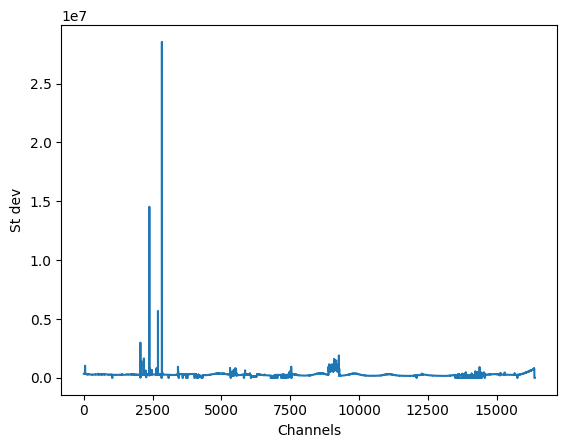

In [124]:
plt.xlabel('Channels')
plt.ylabel('St dev')
plt.plot(np.std(stacked_intensities, axis=1))

In [18]:



def create_filterbank_fileobj(tmpfname, nchans, 
                              nsamples, tsamp, 
                              tstart, beam):
    
    """
        Conver the stacked_intensity to filterbank file
        """
    
    chan_bw = np.abs(800 - 400) / nchans
    header = dict(
        nsamples=nsamples,
        nchans=nchans,
        fch1=800 - chan_bw / 2.0,
        foff=-1.0 * chan_bw,
        nbeams=1,
        ibeam=int(beam),
        nifs=1,
        tsamp=tsamp,
        tstart=tstart,
        data_type=1,
        telescope_id=20,
        machine_id=20,
        nbits=32,
        barycentric=0,
        pulsarcentric=0,
        source_name="Stationary Beam",
        src_raj=0.0,
        src_dej=0.0)

    fil_fileobj = FileWriter(tmpfname,
                             mode="w",
                             tsamp=tsamp,
                             nchans=nchans,
                             nbits=32)
    fil_fileobj.write(sigproc.encode_header(header))

    return fil_fileobj





In [24]:
#Creating the filterbank object
fil_name='mytest.fil'
sampling_time=0.9830*10**(-3)
nchannels=stacked_intensities.shape[0]
nsamples=stacked_intensities.shape[1]


fil_fileobj = create_filterbank_fileobj(fil_name,
                                        *stacked_intensities.shape,
                                        sampling_time,
                                        1, 1)

print('Coverting the msgpack to numpy converted data to filterbank')

#write the data to the filterbank object and dump it in the current directory
fil_fileobj.cwrite(stacked_intensities)
fil_fileobj.close()

Coverting the msgpack to numpy converted data to filterbank


In [120]:
#load the fil data and display the header info
fil_path='mytest.fil'
#"/DATA/chime-slow/injections_results/injection_test/filterbank/2022/06/19/0132/512ms/1655633921_1655648281_beam_0132_512ms_npulses_20_avgDM_0828_81.fil"

fil_file=FilReader(fil_path)
fil_file.header


data = fil_file.read_block(0, 13312)

DM=558.5
tdownsamp=1
subband=16
data[data==0]=np.nan
chan_means=np.nanmean(data,axis=0)
data[:,:]=data[:,:] - chan_means[None,:]
data[np.isnan(data)]=0


data = data.dedisperse(DM)
data = data.downsample(tdownsamp, subband)
data = data.normalise()
tseries = data.get_tim()  #/np.sqrt(data.header.nchans)

/tmp/ipykernel_30940/990459341.py:5: RuntimeWarning: Mean of empty slice
  chan_means=np.nanmean(data,axis=0)


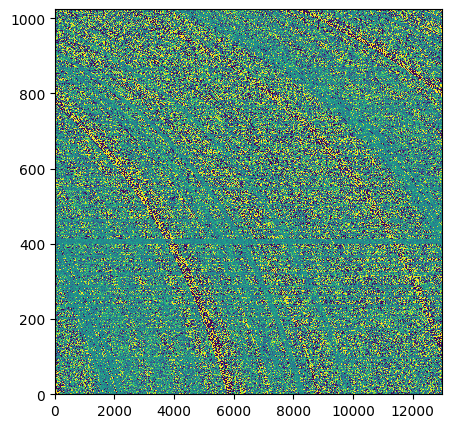

In [123]:
plt.figure(figsize=(5,5))
plt.pcolormesh(data[:,0:13000],vmax=1, vmin=-1 )